In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os

DIR = "/content/drive/MyDrive/Competitions/Signate/OCEAN180"
INPUT_DIR = os.path.join(DIR,"input")
OUTPUT_DIR = os.path.join(DIR,"output")

if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

In [3]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [4]:
train = pd.read_csv(os.path.join(INPUT_DIR,"train_data.csv"))
test = pd.read_csv(os.path.join(INPUT_DIR,"test_data.csv"))
sample_sub = pd.read_csv(os.path.join(INPUT_DIR,"submit_example.csv"), header=None)

print(train.shape)
display(train.head(3))

print(test.shape)
display(test.head(3))

print(sample_sub.shape)
display(sample_sub.head(3))

(14140, 3465)


,Unnamed: 0,lat,lon,area,YMD,year,month,cover,depth_original,cliff_length,...,MIN_NormG_2020,MIN_NormR_2020,MIN_PPR_2020,MIN_PSNDc2_2020,MIN_RDVI_2020,MIN_IF_2020,MIN_SLAVI_2020,MIN_SIPI2_2020,MIN_VARIgreen_2020,mesh20
0,0,24.989139,125.243167,20.0,20110926,2011.0,9.0,0.050,NaN,0.0,...,0.507961,0.287288,-0.278071,-0.808075,-2.341663,2.353039,95.142525,3.728732,-2.405135,3725_10
1,1,26.996172,127.912024,40.0,2009.7.6-2009.7.28,2009.0,7.0,0.725,NaN,0.0,...,0.353645,0.245048,-0.100556,-0.771423,-3.282602,4.672225,174.767501,-0.571513,0.448861,4027_13
2,2,26.363556,127.735139,20.0,20091014,2009.0,10.0,0.025,NaN,0.0,...,0.579204,0.281260,-0.191884,-0.853730,-3.160207,3.324236,62.711236,3.284478,-57.136191,3927_22


(4039, 3464)


,Unnamed: 0,lat,lon,area,YMD,year,month,depth_original,cliff_length,aicial_length,...,MIN_NormG_2020,MIN_NormR_2020,MIN_PPR_2020,MIN_PSNDc2_2020,MIN_RDVI_2020,MIN_IF_2020,MIN_SLAVI_2020,MIN_SIPI2_2020,MIN_VARIgreen_2020,mesh20
0,0,24.352222,124.202674,20.0,2002.12,2002.0,12.0,0.5,0.000000,725.621704,...,0.409346,0.323023,-0.066356,-0.560810,-3.203797,4.297234,926.905329,1.669992,0.194766,3624_20
1,1,24.420028,124.078583,20.0,20100723,2010.0,7.0,NaN,0.000000,0.000000,...,0.540733,0.275585,-0.291240,-0.824888,-2.222276,2.263106,57.661693,4.274851,-79.273275,3624_20
2,2,26.494197,127.836013,100.0,"2004.2.20-2004.2.22,2004.2.27-2004.2.29,2004.3...",2004.0,2.0,13.8,73.183418,80.595177,...,0.601792,0.252251,-0.318454,-0.861477,-2.060505,2.099250,42.672829,5.655713,-2.061417,3927_23


(4039, 2)


,0,1
0,0,0.47
1,1,0.68
2,2,0.25


In [5]:
train.rename(columns={"Unnamed: 0":"id"}, inplace=True)
test.rename(columns={"Unnamed: 0":"id"}, inplace=True)

In [6]:
def missing_func(df):
  total = df.isnull().sum().sort_values(ascending=False)
  percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
  df_missing = pd.concat([total,percent],axis=1,keys=['total','percent'])
  return df_missing 

In [7]:
train_missing = missing_func(train)
test_missing = missing_func(test)

In [8]:
train_cols = train.columns.tolist()
test_cols = test.columns.tolist()

target = set(train_cols) - set(test_cols)
print(target)

display(train[target].head(3))

{'cover'}


,cover
0,0.050
1,0.725
2,0.025


In [9]:
train_missing_50 = train_missing[train_missing.percent<0.5].index
test_missing_50 =  test_missing[test_missing.percent<0.5].index

categorical_features = train.dtypes[train.dtypes=="object"].index

features = set(train_missing_50) & set(test_missing_50)
features = set(features) - set(categorical_features) 

In [10]:
len(features)

3159

In [11]:
land_sat_feats = []
for years in list(range(2000,2021)):
  n_f = [col for col in features if str(years) in col]
  land_sat_feats += n_f
features = [col for col in features if col not in land_sat_feats]

In [12]:
len(features)

309

## Model

In [13]:
#!pip install iterative-stratification

In [14]:
import lightgbm as lgb
from sklearn.neighbors import NearestNeighbors 
from sklearn.model_selection import StratifiedKFold, GroupKFold, StratifiedGroupKFold, KFold
#from iterstrat.ml_stratifiers import MultilabelStratifiedKFold
from sklearn.metrics import mean_squared_error
from sklearn.metrics import f1_score, precision_score, recall_score

In [15]:
class CFG:
  ver=56
  model="lightgbm"
  n_folds=10
  trn_fold=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
  seed=42
  target_cols="cover"
  boosting_type="gbdt"
  fold_target="cover"
  n_neighbors = 3

In [16]:
# =========================================================================================
# CV split
# =========================================================================================
def get_fold(df):
  Fold = KFold(n_splits=CFG.n_folds, shuffle=True, random_state=CFG.seed)
  for n, (train_index, val_index) in enumerate(Fold.split(df)):
      df.loc[val_index, 'fold'] = int(n)
  df['fold'] = df['fold'].astype(int)
  display(df.groupby('fold').size())
  return df

In [17]:
def get_score(labels, preds):
  rmse = np.sqrt(mean_squared_error(labels, preds))
  print(f"RMSE {rmse}")

In [18]:
#features = list(features)
features.remove('id')
features.remove('area')
features.remove("year")
#features.remove("month")
features.append("mesh20")

In [19]:
params = {
        'objective': 'regression',
        'metric': 'rmse',
        'learning_rate': 0.05,
        'boosting': "dart",
        'seed': CFG.seed,
        "reg_alpha":0.1,
        "n_estimators":2000
    }

In [20]:
def get_pred(df, test, target_cols, model):
  train = get_fold(df)
  oof_df = pd.DataFrame()
  df_importance = pd.DataFrame({'feature': features})
  df_importance['importance'] = 0
  test_preds = np.zeros((len(test), CFG.n_folds))

  ctg_list = ["year","month","mesh20"]

  for fold in range(CFG.n_folds):
    if fold in CFG.trn_fold:
      print("="*15,f" FOLD : {fold} ","="*15)
      train_folds = train[train.fold != fold]
      valid_folds = train[train.fold == fold]


      train_X = train_folds[features].values
      valid_X = valid_folds[features].values
      test_X = test[features].values
      train_labels = train_folds[target_cols].values
      valid_labels = valid_folds[target_cols].values

      clf = model
      #model = lgb.LGBMRegressor(**params)
      clf.fit(train_X, train_labels,
              eval_set=[(valid_X, valid_labels)],
              #eval_metric="rmse",
              #categorical_feature = ctg_list,
              verbose = 500,
              early_stopping_rounds=50)
      
      valid_folds[f"pred"] = model.predict(valid_X)
      test_preds[:, fold] = model.predict(test_X)
      oof_df = pd.concat([oof_df, valid_folds])

      f_importance = np.array(model.feature_importances_)
      temp_importance = pd.DataFrame({'feature': features, 'importance': f_importance})
      df_importance['importance'] += temp_importance['importance']

      get_score(valid_labels, valid_folds[f"pred"])

  df_importance['importance'] = df_importance['importance'] / np.sum(df_importance['importance'])
  df_importance = df_importance.sort_values('importance', ascending=False)
  display(df_importance.head(35))
  fig = plt.figure(figsize=(16, 32), tight_layout=True)
  sns.barplot(x="importance", y="feature", data=df_importance.head(35))
  plt.title("LightGBM feature importances")
  get_score(oof_df[target_cols], oof_df[f"pred"])
  return oof_df,  test_preds

In [21]:
knn_train = train.copy()
knn_test = test.copy()
knn_train[features] = knn_train[features].fillna(9999)
knn_test[features] = knn_test[features].fillna(9999)


knn = NearestNeighbors(n_neighbors=CFG.n_neighbors, algorithm='auto').fit(knn_train[features].values)
_, indices = knn.kneighbors(knn_test[features].values) 

In [22]:
indices_list = []
for i in range(indices.shape[0]):
  indices_list.extend(indices[i])

inds_list = set(indices_list)
train = train[train.index.isin(inds_list)].reset_index(drop=True)
print(train.shape)

(3466, 3465)


fold
0    347
1    347
2    347
3    347
4    347
5    347
6    346
7    346
8    346
9    346
dtype: int64

===============  FOLD : 0  ===============


/usr/local/lib/python3.8/dist-packages/lightgbm/callback.py:189: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')


[500]	valid_0's rmse: 0.140908
[1000]	valid_0's rmse: 0.139648
[1500]	valid_0's rmse: 0.138539
[2000]	valid_0's rmse: 0.138677


<ipython-input-20-081612cb00d2>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"pred"] = model.predict(valid_X)


RMSE 0.13867545383097946
===============  FOLD : 1  ===============


/usr/local/lib/python3.8/dist-packages/lightgbm/callback.py:189: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')


[500]	valid_0's rmse: 0.148239
[1000]	valid_0's rmse: 0.143429
[1500]	valid_0's rmse: 0.14139
[2000]	valid_0's rmse: 0.141223


<ipython-input-20-081612cb00d2>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"pred"] = model.predict(valid_X)


RMSE 0.14122275576499696
===============  FOLD : 2  ===============


/usr/local/lib/python3.8/dist-packages/lightgbm/callback.py:189: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')


[500]	valid_0's rmse: 0.120677
[1000]	valid_0's rmse: 0.116847
[1500]	valid_0's rmse: 0.116866
[2000]	valid_0's rmse: 0.117293


<ipython-input-20-081612cb00d2>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"pred"] = model.predict(valid_X)


RMSE 0.11729275797210711
===============  FOLD : 3  ===============


/usr/local/lib/python3.8/dist-packages/lightgbm/callback.py:189: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')


[500]	valid_0's rmse: 0.144642
[1000]	valid_0's rmse: 0.138953
[1500]	valid_0's rmse: 0.138236
[2000]	valid_0's rmse: 0.137032


<ipython-input-20-081612cb00d2>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"pred"] = model.predict(valid_X)


RMSE 0.13703218264572675
===============  FOLD : 4  ===============


/usr/local/lib/python3.8/dist-packages/lightgbm/callback.py:189: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')


[500]	valid_0's rmse: 0.137197
[1000]	valid_0's rmse: 0.137171
[1500]	valid_0's rmse: 0.13759
[2000]	valid_0's rmse: 0.13792


<ipython-input-20-081612cb00d2>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"pred"] = model.predict(valid_X)


RMSE 0.13792011214724256
===============  FOLD : 5  ===============


/usr/local/lib/python3.8/dist-packages/lightgbm/callback.py:189: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')


[500]	valid_0's rmse: 0.128304
[1000]	valid_0's rmse: 0.128038
[1500]	valid_0's rmse: 0.127228
[2000]	valid_0's rmse: 0.127521


<ipython-input-20-081612cb00d2>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"pred"] = model.predict(valid_X)


RMSE 0.1275188345328653
===============  FOLD : 6  ===============


/usr/local/lib/python3.8/dist-packages/lightgbm/callback.py:189: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')


[500]	valid_0's rmse: 0.142151
[1000]	valid_0's rmse: 0.137897
[1500]	valid_0's rmse: 0.13744
[2000]	valid_0's rmse: 0.136504


<ipython-input-20-081612cb00d2>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"pred"] = model.predict(valid_X)


RMSE 0.13650416744808264
===============  FOLD : 7  ===============


/usr/local/lib/python3.8/dist-packages/lightgbm/callback.py:189: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')


[500]	valid_0's rmse: 0.115881
[1000]	valid_0's rmse: 0.108182
[1500]	valid_0's rmse: 0.107802
[2000]	valid_0's rmse: 0.106544


<ipython-input-20-081612cb00d2>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"pred"] = model.predict(valid_X)


RMSE 0.10654411227138823
===============  FOLD : 8  ===============


/usr/local/lib/python3.8/dist-packages/lightgbm/callback.py:189: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')


[500]	valid_0's rmse: 0.138992
[1000]	valid_0's rmse: 0.136962
[1500]	valid_0's rmse: 0.137506
[2000]	valid_0's rmse: 0.136687


<ipython-input-20-081612cb00d2>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"pred"] = model.predict(valid_X)


RMSE 0.13668686322932405
===============  FOLD : 9  ===============


/usr/local/lib/python3.8/dist-packages/lightgbm/callback.py:189: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')


[500]	valid_0's rmse: 0.135429
[1000]	valid_0's rmse: 0.128497
[1500]	valid_0's rmse: 0.128017
[2000]	valid_0's rmse: 0.127548


<ipython-input-20-081612cb00d2>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"pred"] = model.predict(valid_X)


RMSE 0.12754812236214794


,feature,importance
75,depth,0.035378
285,warm_sst,0.032212
219,lat,0.026523
80,MIN_GARI,0.022140
97,hist_warm_sst,0.021058
199,river_dist,0.020060
84,fetch,0.017445
6,MIN_GLI,0.016190
165,MAX_GVMI,0.013688
89,MAX_CI,0.013315


RMSE 0.13112630996364735


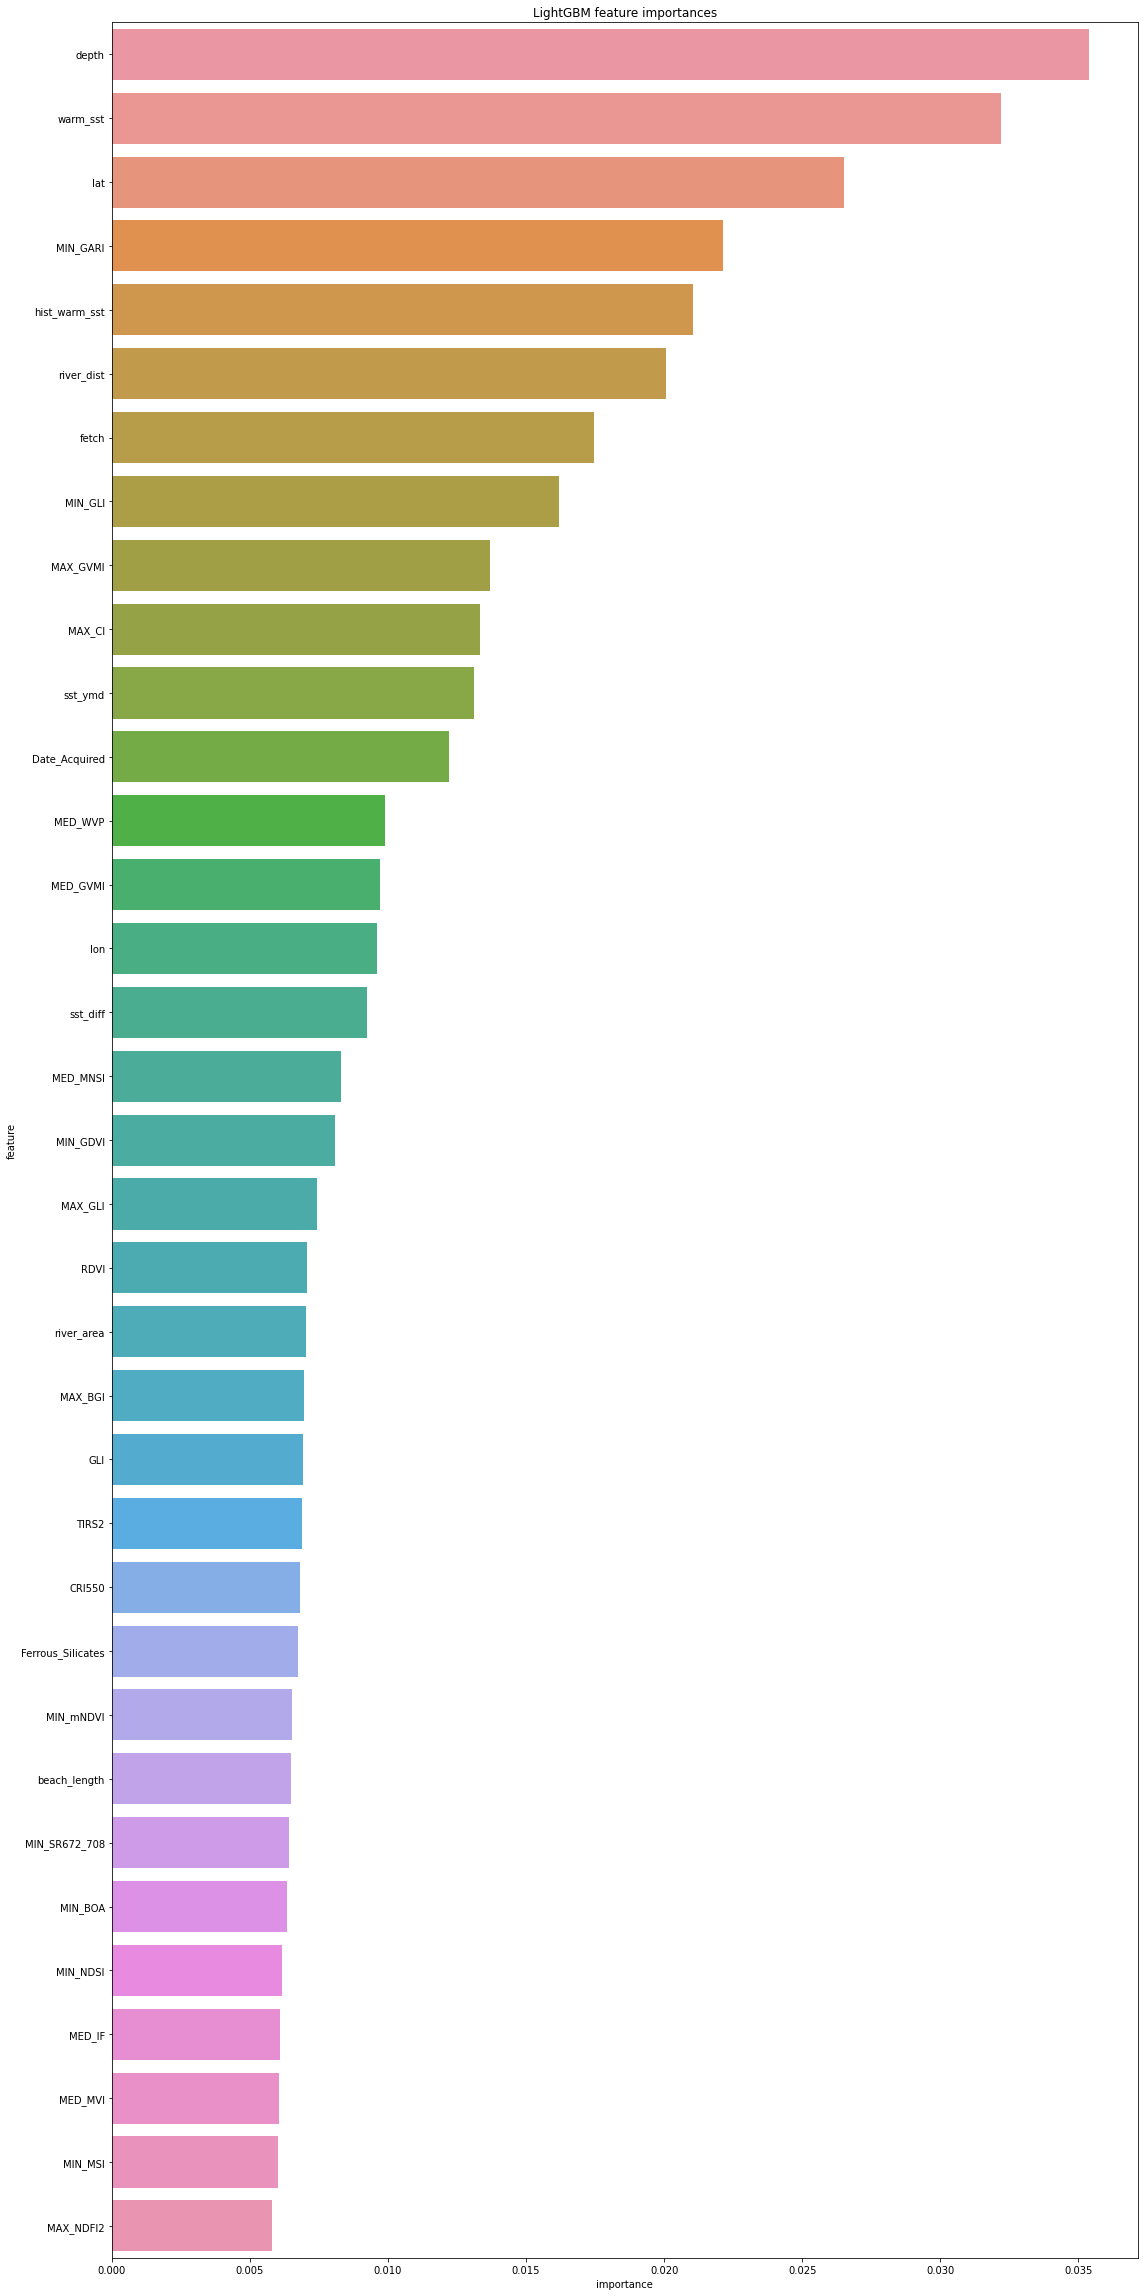

In [23]:
model = lgb.LGBMRegressor(**params)
oof_df, test_pred = get_pred(train, test, CFG.target_cols, model)

In [24]:
cover_max = train.cover.max()
_oof = oof_df.copy()
_oof["pred"] = _oof["pred"].apply(lambda x: x if x>0 else 0)
_oof["pred"] = _oof["pred"].apply(lambda x: x if x<1 else cover_max)
get_score(_oof["cover"], _oof["pred"])

RMSE 0.1311243732524053


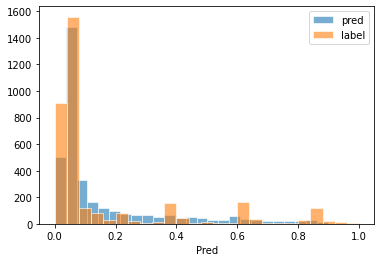

In [25]:
plt.hist(_oof.pred, label='pred', bins=25, edgecolor='white', alpha=.6)
plt.hist(_oof.cover, label="label", bins=25, edgecolor='white', alpha=.6)
plt.xlabel("Pred")
plt.legend()
plt.show()

In [26]:
pred_df = test.copy()
pred_df["pred"] = np.mean(test_pred, axis=1)

pred_df = pred_df.sort_index()
pred_df

,id,lat,lon,area,YMD,year,month,depth_original,cliff_length,aicial_length,...,MIN_NormR_2020,MIN_PPR_2020,MIN_PSNDc2_2020,MIN_RDVI_2020,MIN_IF_2020,MIN_SLAVI_2020,MIN_SIPI2_2020,MIN_VARIgreen_2020,mesh20,pred
0,0,24.352222,124.202674,20.0,2002.12,2002.0,12.0,0.5,0.000000,725.621704,...,0.323023,-0.066356,-0.560810,-3.203797,4.297234,926.905329,1.669992,0.194766,3624_20,0.018421
1,1,24.420028,124.078583,20.0,20100723,2010.0,7.0,NaN,0.000000,0.000000,...,0.275585,-0.291240,-0.824888,-2.222276,2.263106,57.661693,4.274851,-79.273275,3624_20,0.068355
2,2,26.494197,127.836013,100.0,"2004.2.20-2004.2.22,2004.2.27-2004.2.29,2004.3...",2004.0,2.0,13.8,73.183418,80.595177,...,0.252251,-0.318454,-0.861477,-2.060505,2.099250,42.672829,5.655713,-2.061417,3927_23,0.061169
3,3,26.183639,127.319361,20.0,20100805,2010.0,8.0,NaN,0.000000,0.000000,...,0.270476,-0.320391,-0.863338,-2.708627,-10.433323,45.061952,1.546086,-14.527890,3927_11,0.040959
4,4,24.761089,125.269009,20.0,NaN,2019.0,10.0,-0.5,0.000000,34.796036,...,0.314171,-0.231658,-0.824787,-5.249625,2.563503,80.374689,1.827876,-6.335208,3725_01,0.417724
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4034,4034,26.702075,127.873347,20.0,NaN,2019.0,9.0,0.4,0.000000,20.594961,...,0.260930,-0.187582,-0.861148,-3.207146,3.633575,60.936945,3.053976,-28.354402,4027_03,0.056216
4035,4035,24.337028,124.232694,20.0,20101122,2010.0,11.0,NaN,0.000000,0.000000,...,0.286240,-0.264021,-0.833596,-2.385447,2.495430,75.231230,3.946128,-2.112646,3624_20,0.049034
4036,4036,26.493121,127.839918,100.0,"2004.2.20-2004.2.22,2004.2.27-2004.2.29,2004.3...",2004.0,2.0,0.1,76.439651,133.127228,...,0.316359,-0.123194,-0.843974,-4.397375,4.403977,117.513676,1.904304,0.601280,3927_23,0.322007
4037,4037,24.068778,123.804194,20.0,20110415,2011.0,4.0,NaN,73.660492,0.000000,...,0.302570,-0.276085,-0.788681,-3.821984,2.203933,121.654726,2.282056,-2.029225,3623_03,0.205144


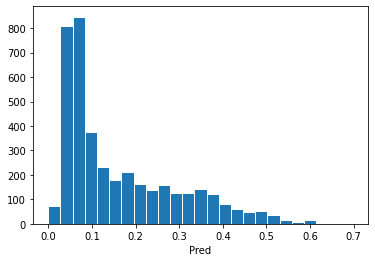

,id,lat,lon,area,YMD,year,month,depth_original,cliff_length,aicial_length,...,MIN_NormR_2020,MIN_PPR_2020,MIN_PSNDc2_2020,MIN_RDVI_2020,MIN_IF_2020,MIN_SLAVI_2020,MIN_SIPI2_2020,MIN_VARIgreen_2020,mesh20,pred
0,0,24.352222,124.202674,20.0,2002.12,2002.0,12.0,0.5,0.000000,725.621704,...,0.323023,-0.066356,-0.560810,-3.203797,4.297234,926.905329,1.669992,0.194766,3624_20,0.018421
1,1,24.420028,124.078583,20.0,20100723,2010.0,7.0,NaN,0.000000,0.000000,...,0.275585,-0.291240,-0.824888,-2.222276,2.263106,57.661693,4.274851,-79.273275,3624_20,0.068355
2,2,26.494197,127.836013,100.0,"2004.2.20-2004.2.22,2004.2.27-2004.2.29,2004.3...",2004.0,2.0,13.8,73.183418,80.595177,...,0.252251,-0.318454,-0.861477,-2.060505,2.099250,42.672829,5.655713,-2.061417,3927_23,0.061169
3,3,26.183639,127.319361,20.0,20100805,2010.0,8.0,NaN,0.000000,0.000000,...,0.270476,-0.320391,-0.863338,-2.708627,-10.433323,45.061952,1.546086,-14.527890,3927_11,0.040959
4,4,24.761089,125.269009,20.0,NaN,2019.0,10.0,-0.5,0.000000,34.796036,...,0.314171,-0.231658,-0.824787,-5.249625,2.563503,80.374689,1.827876,-6.335208,3725_01,0.417724
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4034,4034,26.702075,127.873347,20.0,NaN,2019.0,9.0,0.4,0.000000,20.594961,...,0.260930,-0.187582,-0.861148,-3.207146,3.633575,60.936945,3.053976,-28.354402,4027_03,0.056216
4035,4035,24.337028,124.232694,20.0,20101122,2010.0,11.0,NaN,0.000000,0.000000,...,0.286240,-0.264021,-0.833596,-2.385447,2.495430,75.231230,3.946128,-2.112646,3624_20,0.049034
4036,4036,26.493121,127.839918,100.0,"2004.2.20-2004.2.22,2004.2.27-2004.2.29,2004.3...",2004.0,2.0,0.1,76.439651,133.127228,...,0.316359,-0.123194,-0.843974,-4.397375,4.403977,117.513676,1.904304,0.601280,3927_23,0.322007
4037,4037,24.068778,123.804194,20.0,20110415,2011.0,4.0,NaN,73.660492,0.000000,...,0.302570,-0.276085,-0.788681,-3.821984,2.203933,121.654726,2.282056,-2.029225,3623_03,0.205144


In [27]:
pred_df["pred"] = pred_df["pred"].apply(lambda x: x if x>0 else 0)
pred_df["pred"] = pred_df["pred"].apply(lambda x: x if x<1 else 1)
pred_df[["pred"]].to_csv(os.path.join(OUTPUT_DIR, f'submit_{CFG.model}_seed{CFG.seed}_ver{CFG.ver}.csv'), header=False)

plt.hist(pred_df.pred,bins=25,edgecolor='white')
plt.xlabel("Pred")
plt.show()

display(pred_df)